In [1]:
import numpy as np

import torch 
from torchvision import datasets, transforms

from pyhessian import hessian # Hessian computation

from utils_pyh import * # get the dataset

from density_plot import get_esd_plot # ESD plot
from pytorchcv.model_provider import get_model as ptcv_get_model # model

import matplotlib.pyplot as plt

import sys

sys.path.append("../")
import cifar.models

import copy

%matplotlib inline

In [2]:
parent1 = cifar.models.VGG('VGG11', 10, batch_norm=False, bias=False, relu_inplace=True)
parent2 = cifar.models.VGG('VGG11', 10, batch_norm=False, bias=False, relu_inplace=True)
fusion = cifar.models.VGG('VGG11', 10, batch_norm=False, bias=False, relu_inplace=True)

in _make_layers [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [3]:
sum(p.numel() for p in parent1.parameters())

9222848

In [3]:
state1 = torch.load("../cifar_models/model_0/best.checkpoint", map_location=torch.device('cpu'))
state2 = torch.load("../cifar_models/model_1/best.checkpoint", map_location=torch.device('cpu'))
state3 = torch.load("../cifar_models/fusion_retraining/best.checkpoint", map_location=torch.device('cpu'))

In [4]:
parent1.load_state_dict(state1['model_state_dict'])
parent2.load_state_dict(state2['model_state_dict'])
fusion.load_state_dict(state3['model_state_dict'])

<All keys matched successfully>

In [5]:
criterion = torch.nn.CrossEntropyLoss()
BATCH_SIZE = 32

# # get dataset 
# train_loader, test_loader = getData()

test_loader = torch.utils.data.DataLoader(
                datasets.CIFAR10('../data/', train=False, download=True,
                                           transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize(
                                                   # (mean_ch1, mean_ch2, mean_ch3), (std1, std2, std3)
                                                   (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ])),
                batch_size = BATCH_SIZE, shuffle=True
            )

# for illustrate, we only use one batch to do the tutorial
# for inputs, targets in test_loader:
#     break


Files already downloaded and verified


In [7]:
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        # print("param: ", m_orig.data.shape)
        # print("direction: ", d.shape)
        m_perb.data = m_orig.data + alpha * d
    return model_perb

def param_landscape_hessian_eig(models, loader):
    # lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
    lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)
    labels = ["parent1", "parent2", "fusion"]


    ev_total = []
    trace_total = []
    loss_list_total = []
    for k, (inputs, targets) in enumerate(loader):
        if k >= 10: break
        
        ev_models = []
        trace_models = []
        loss_list_models = []
        
        for i, model in enumerate(models):
            hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=False) # cuda=True
            trace = hessian_comp.trace()

            top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=3)
            loss_list = []
            
            # create a copy of the model
            model_perb = copy.deepcopy(model)
            model_perb.eval()
            # model_perb = model_perb.cuda()

            for lam in lams:
                model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
                loss_list.append(criterion(model_perb(inputs), targets).item())
            
            ev_models.append(top_eigenvalues)
            loss_list_models.append(loss_list)
            trace_models.append(np.mean(trace))
        
        ev_total.append(ev_models)
        loss_list_total.append(loss_list_models)
        trace_total.append(trace_models)

    return loss_list_total, ev_total, trace_total

In [8]:
result, evs, traces = param_landscape_hessian_eig([parent1, parent2, fusion], test_loader)

/Users/geventh/miniforge3/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1176.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [9]:
traces_np = np.array(traces)
mean_traces = traces_np.mean(axis=0)
std_traces = traces_np.std(axis=0)

In [10]:
mean_traces

array([ 987.40553013, 1166.91122102, 1267.08059294])

In [11]:
evs_np = np.array(evs)
mean_evs = evs_np.mean(axis=0)
std_evs = evs_np.std(axis=0)

In [12]:
print("Parent 1:", mean_evs[0])
print("Parent 2:", mean_evs[1])
print("Fusion 3:", mean_evs[2])

Parent 1: [142.00309143  94.17894287  78.64593086]
Parent 2: [153.65075836 110.62094498  86.75561447]
Fusion 3: [157.84359665 119.28403625  99.21053696]


In [13]:
result_np = np.array(result)
mean = result_np.mean(axis=0)
std = result_np.std(axis=0)

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

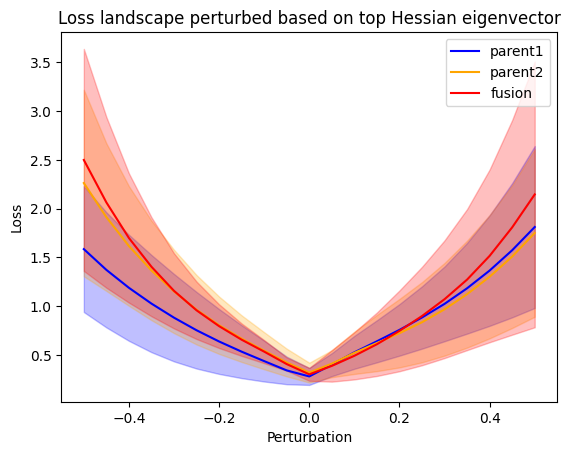

In [16]:
labels = ["parent1", "parent2", "fusion"]
colors = ["blue", "orange", "red"]
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

for i in range(mean.shape[0]):
    plt.fill_between(lams, mean[i] + std[i], mean[i] - std[i], alpha = 0.25, color = colors[i])
    plt.plot(lams, mean[i], label=labels[i], color = colors[i])

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector')

In [22]:
def plot_param_landscape_hessian_eig(models, eigenvectors):
    # lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
    lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

    labels = ["parent1", "parent2", "fusion"]

    for i, model in enumerate(models):
        loss_list = []
        
        # create a copy of the model
        model_perb = copy.deepcopy(model)
        model_perb.eval()
        # model_perb = model_perb.cuda()

        for lam in lams:
            model_perb = get_params(model, model_perb, eigenvectors[i], lam)
            loss_list.append(criterion(model_perb(inputs), targets).item())

        plt.plot(lams, loss_list, label=labels[i])
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Perturbation')
    plt.title('Loss landscape perturbed based on top Hessian eigenvector')